In [1]:
!pip install feedparser TextBlob
!pip install nltk transformers torch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.4 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=8f17c1cc8126c204c455ed47bf528a4f0ea1f28cea040c2c460c69b01809ad94
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [2]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import requests
import feedparser
import sqlite3
from datetime import datetime

# Download necessary NLTK data
nltk.download('vader_lexicon', quiet=True)

# Initialize NLTK's VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Load pre-trained FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Load the additional transformers models
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Function to perform sentiment analysis using RoBERTa
def roberta_sentiment_analysis(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = roberta_model(**inputs)
    roberta_probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    roberta_sentiment = torch.argmax(roberta_probs).item()
    return roberta_sentiment * 5, torch.max(roberta_probs).item()

# BART summarization for long texts
def generate_summary(text):
    if len(text) > 1000:
        summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
        return summary[0]['summary_text']
    return text

# Main sentiment analysis function
def analyze_sentiment(text):
    # Handle missing or short summaries
    if not text or len(text.strip()) < 10:
        return 5.0  # Neutral score for missing or insufficient text

    # Generate summary if the text is too long
    summarized_text = generate_summary(text)

    # VADER sentiment analysis
    vader_score = sia.polarity_scores(summarized_text)
    normalized_vader_score = (vader_score['compound'] + 1) * 5

    # FinBERT sentiment analysis
    inputs = tokenizer(summarized_text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    finbert_probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    finbert_sentiment = torch.argmax(finbert_probs).item()
    normalized_finbert_score = finbert_sentiment * 5

    # RoBERTa sentiment analysis
    roberta_score, roberta_confidence = roberta_sentiment_analysis(summarized_text)

    # Confidence-based adjustment
    finbert_confidence = torch.max(finbert_probs).item()  # Confidence of the highest FinBERT class
    vader_confidence = abs(vader_score['compound'])  # VADER confidence derived from compound score
    total_confidence = finbert_confidence + vader_confidence + roberta_confidence

    # Assign weights based on confidence
    finbert_weight = finbert_confidence / total_confidence
    vader_weight = vader_confidence / total_confidence
    roberta_weight = roberta_confidence / total_confidence

    # Combine the scores based on weighted confidence
    combined_score = (
        (vader_weight * normalized_vader_score) +
        (finbert_weight * normalized_finbert_score) +
        (roberta_weight * roberta_score)
    )

    # Ensure the combined score remains between 0 and 10
    combined_score = max(0, min(combined_score, 10))

    return post_process_sentiment_score(summarized_text, combined_score)

# Post-processing to handle edge cases
def post_process_sentiment_score(text, score):
    # Check for certain keywords that may skew sentiment (e.g., hospital, critical, death)
    negative_keywords = ['hospital', 'intensive care', 'critical', 'death', 'emergency']
    positive_keywords = ['good spirits', 'recovery', 'improving', 'healthy']

    for word in negative_keywords:
        if word in text.lower():
            score = min(score, 4.0)  # Cap the score on the lower side

    for word in positive_keywords:
        if word in text.lower() and score < 5:
            score = max(score, 6.0)  # Raise the score slightly if positive keywords found

    return score

# Database setup
def setup_database():
    conn = sqlite3.connect('news_sentiment.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS sentiment_scores
                 (date TEXT, time TEXT, title TEXT, summary TEXT, score REAL)''')
    conn.commit()
    return conn

# Store the sentiment score in the database
def store_score(conn, date, time, title, summary, score):
    c = conn.cursor()
    c.execute("INSERT INTO sentiment_scores VALUES (?, ?, ?, ?, ?)",
              (date, time, title, summary, score))
    conn.commit()

# Fetch news and analyze sentiment
def fetch_news_and_analyze(url, conn):
    response = requests.get(url)
    feed = feedparser.parse(response.content)

    for entry in feed.entries:
        title = entry.title
        summary = entry.summary
        published = entry.published

        # Parse the published date and time
        dt = datetime.strptime(published, "%a, %d %b %Y %H:%M:%S %z")
        date = dt.strftime("%Y-%m-%d")
        time = dt.strftime("%H:%M:%S")

        score = analyze_sentiment(summary)

        print(f"Title: {title}")
        print(f"Published: {published}")
        print(f"Summary: {summary}")
        print(f"Sentiment Score: {score:.2f}")
        print("---")

        # Store in the database
        store_score(conn, date, time, title, summary, score)

# Get the daily average sentiment score
def get_daily_average(conn, date):
    c = conn.cursor()
    c.execute("SELECT AVG(score) FROM sentiment_scores WHERE date = ?", (date,))
    return c.fetchone()[0]

# Main script
url = "https://timesofindia.indiatimes.com/rssfeedstopstories.cms"

# Setup the database
conn = setup_database()

# Fetch news, analyze sentiment, and store in database
fetch_news_and_analyze(url, conn)

# Get today's date
today = datetime.now().strftime("%Y-%m-%d")

# Calculate and print daily average
daily_avg = get_daily_average(conn, today)
print(f"Average sentiment score for today ({today}): {daily_avg:.2f}")

# Close the database connection
conn.close()

print("Data has been stored in the 'news_sentiment.db' database.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Title: Baba Siddique murder: Key suspect Lonkar was quizzed in Salman firing case, let off
Published: Tue, 15 Oct 2024 03:50:54 +0530
Summary: A potential oversight by Mumbai police in not thoroughly investigating Shubham Lonkar, a suspect in the Salman Khan shooting case, might have led to the killing of Baba Siddique. Lonkar, connected to the Bishnoi gang, allegedly recruited new shooters and claimed responsibility for Siddique's murder.
Sentiment Score: 1.64
---
Title: Five flights, including Delhi-Chicago Air India plane, get bomb threats online
Published: Tue, 15 Oct 2024 17:42:37 +0530
Summary: Five flights, including Air India's Delhi-Chicago route, faced bomb threats online, prompting diversions and security drills. The Air India flight was diverted to Canada for checks, while other flights from Air India Express, SpiceJet, and Akasa Air also underwent security inspections. Recent hoax threats have signaled ongoing security challenges in aviation.
Sentiment Score: 2.68
---
Titl

In [3]:
import sqlite3
import pandas as pd

def check_database_entries():
    # Connect to the SQLite database
    conn = sqlite3.connect('news_sentiment.db')

    # Create a cursor object
    cursor = conn.cursor()

    # Get the number of entries in the database
    cursor.execute("SELECT COUNT(*) FROM sentiment_scores")
    count = cursor.fetchone()[0]
    print(f"Total number of entries in the database: {count}")

    # Fetch all entries
    df = pd.read_sql_query("SELECT * FROM sentiment_scores", conn)

    # Display the first few rows
    print("\nFirst few entries:")
    print(df.head())

    # Display summary statistics
    print("\nSummary statistics of sentiment scores:")
    print(df['score'].describe())

    # Check for any null values
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print("\nWarning: Null values found in the following columns:")
        print(null_counts[null_counts > 0])
    else:
        print("\nNo null values found in the database.")

    # Check the date range of the entries
    print(f"\nDate range of entries:")
    print(f"Earliest date: {df['date'].min()}")
    print(f"Latest date: {df['date'].max()}")

    # Close the connection
    conn.close()

# Run the database check
check_database_entries()

Total number of entries in the database: 302

First few entries:
         date      time                                              title  \
0  2024-10-10  09:30:11  'Will spend rest of my life ... ': Tata's youn...   
1  2024-10-09  23:31:05  ‘Acid’ attack on Syrian refugee, son: Delhi ac...   
2  2024-10-10  09:40:58    Cricket legends who were employed by Ratan Tata   
3  2024-10-10  09:22:29  Star Health on 3.2 crore customers data sellin...   
4  2024-10-10  09:14:07  Atishi bungalow row: AAP says BJP has anti-wom...   

                                             summary     score  
0  Shantanu Naidu, Ratan Tata's trusted assistant...  4.000000  
1  In west Delhi's Vikaspuri, a group of locals a...  1.797752  
2  Ratan Tata, the respected industrialist and ph...  9.607198  
3  A hacker claims to have released sensitive dat...  2.867059  
4  The AAP has condemned the BJP for allegedly fo...  2.912162  

Summary statistics of sentiment scores:
count    302.000000
mean       5.03

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


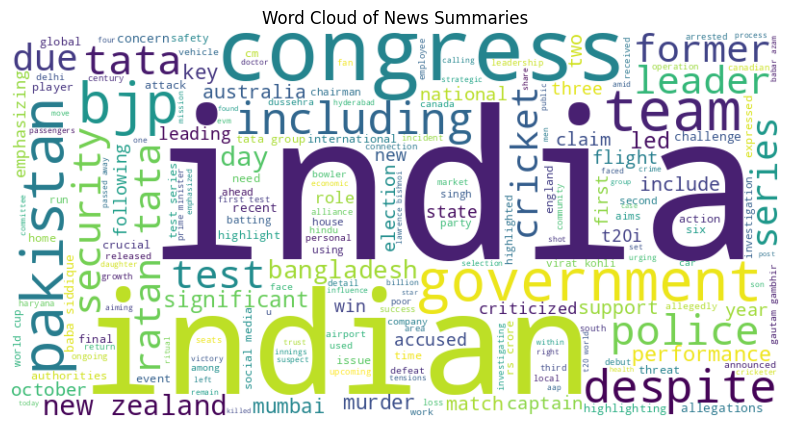

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
from scipy import stats

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def load_data():
    conn = sqlite3.connect('news_sentiment.db')
    df = pd.read_sql_query("SELECT * FROM sentiment_scores", conn)
    df['date'] = pd.to_datetime(df['date'])
    conn.close()
    return df

def create_word_cloud(df):
    # Combine all summaries
    text = ' '.join(df['summary'])

    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text.lower())
    filtered_text = [word for word in word_tokens if word.isalnum() and word not in stop_words]

    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_text))

    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of News Summaries')
    plt.show()

def plot_average_sentiment(df):
    daily_avg = df.groupby('date')['score'].mean().reset_index()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=daily_avg['date'], y=daily_avg['score'], mode='lines+markers'))
    fig.update_layout(title='Average Daily Sentiment Score',
                      xaxis_title='Date',
                      yaxis_title='Average Sentiment Score')
    fig.show()

def plot_sentiment_distribution(df):
  fig = go.Figure()
  fig.add_trace(go.Histogram(
      x=df['score'],
      # histfunc="auto",  # This line is causing the error
      histfunc="count",  # Changed to 'count' as a valid option
      nbinsx=20,
      histnorm="probability"
  ))
  fig.update_layout(
      title='Distribution of Sentiment Scores',
      xaxis_title='Sentiment Score',
      yaxis_title='Probability Density'
  )
  fig.show()

def time_series_analysis(df):
    daily_avg = df.groupby('date')['score'].mean().reset_index()
    daily_avg.set_index('date', inplace=True)

    # Compute rolling average
    rolling_avg = daily_avg['score'].rolling(window=7).mean()

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                        subplot_titles=('Daily Average Sentiment', '7-day Rolling Average'))

    fig.add_trace(go.Scatter(x=daily_avg.index, y=daily_avg['score'], mode='lines', name='Daily Average'),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=rolling_avg.index, y=rolling_avg, mode='lines', name='7-day Rolling Average'),
                  row=2, col=1)

    fig.update_layout(height=600, title_text="Time Series Analysis of Sentiment Scores")
    fig.show()

def word_count_sentiment_correlation(df):
    df['word_count'] = df['summary'].apply(lambda x: len(x.split()))

    correlation, p_value = stats.pearsonr(df['word_count'], df['score'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['word_count'],
        y=df['score'],
        mode='markers',
        marker=dict(color='blue', opacity=0.5)  # Set opacity within the marker dictionary
    ))
    fig.update_layout(
        title=f'Word Count vs Sentiment Score (Correlation: {correlation:.2f}, p-value: {p_value:.4f})',
        xaxis_title='Word Count (Title + Subtitle)',
        yaxis_title='Sentiment Score'
    )
    fig.show()

def main():
    df = load_data()

    create_word_cloud(df)
    plot_average_sentiment(df)
    analyze_top_genres(df)
    plot_sentiment_distribution(df)
    time_series_analysis(df)
    word_count_sentiment_correlation(df)

if __name__ == "__main__":
    main()

In [9]:
import sqlite3

def remove_single_word_entry():
    conn = sqlite3.connect('news_sentiment.db')
    cursor = conn.cursor()

    # Execute the DELETE statement with the condition
    cursor.execute("DELETE FROM sentiment_scores WHERE LENGTH(summary) <= 2")

    conn.commit()
    conn.close()
    print("Entry with one word in summary removed from the database.")

# Call the function to remove the entry
remove_single_word_entry()

Entry with one word in summary removed from the database.
